# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'
!pip install tqdm
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 51kB 2.9MB/s ta 0:00:01
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

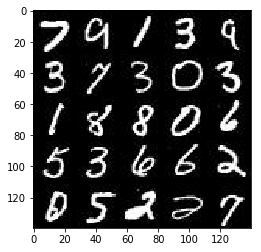

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

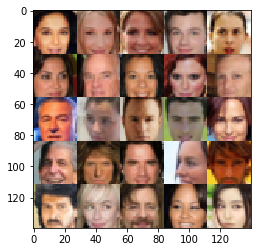

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha = 0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # size of input layer = 24 x 24 x 3
        
        # 1st convolution layer 14 x 14 x 64
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        
        # 2nd convolution layer 7 x 7 x 128 with batch normalization 
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        batch_norm2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        # 3rd convolution layer 4 x 4 x 256 with batch normalization
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        batch_norm3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        
        # Flatten - sigmoid activation 
        flat = tf.reshape(relu3, (-1, 4096))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def leaky_relu(x, alpha=0.1, name='leaky_relu'):
    return tf.maximum(x, alpha * x, name=name)

def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
   
    with tf.variable_scope('generator', reuse = not is_train):
        
        x1 = tf.reshape(tf.layers.dense(z, 4*4*256), (-1,4,4,256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        x1 = tf.nn.dropout(x1, 0.90)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=3, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        x2 = tf.nn.dropout(x2, 0.90)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        x3 = tf.nn.dropout(x3, 0.90)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='valid')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        d_train_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_op, g_train_op


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, learning_rate_t = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    i = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):  
                # TODO: Train Model
                
                i += 1
                
                # Random noise to be passed into the Generator
                batch_z = np.random.uniform(-1, 1, size=[batch_size, z_dim])
                
                if data_image_mode == 'RGB':
                    batch_images *= 2.0
                
                # Running optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z:batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z:batch_z, input_real: batch_images})
                
                if i%10 == 0:
                    train_loss_d = d_loss.eval({input_z:batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z:batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if i%100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4756... Generator Loss: 2.2907
Epoch 1/2... Discriminator Loss: 0.4873... Generator Loss: 6.8407
Epoch 1/2... Discriminator Loss: 0.3827... Generator Loss: 4.2200
Epoch 1/2... Discriminator Loss: 0.4217... Generator Loss: 3.5059
Epoch 1/2... Discriminator Loss: 0.5216... Generator Loss: 8.9273
Epoch 1/2... Discriminator Loss: 0.3615... Generator Loss: 4.2423
Epoch 1/2... Discriminator Loss: 5.1866... Generator Loss: 18.7569
Epoch 1/2... Discriminator Loss: 0.6759... Generator Loss: 1.8319
Epoch 1/2... Discriminator Loss: 0.4219... Generator Loss: 3.6416
Epoch 1/2... Discriminator Loss: 1.4654... Generator Loss: 0.5748


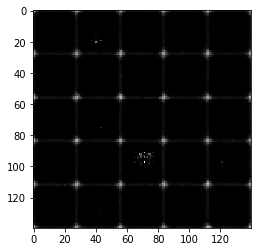

Epoch 1/2... Discriminator Loss: 0.5136... Generator Loss: 2.6838
Epoch 1/2... Discriminator Loss: 0.4420... Generator Loss: 3.2837
Epoch 1/2... Discriminator Loss: 0.5000... Generator Loss: 2.6179
Epoch 1/2... Discriminator Loss: 0.4428... Generator Loss: 4.5282
Epoch 1/2... Discriminator Loss: 0.4721... Generator Loss: 2.3222
Epoch 1/2... Discriminator Loss: 0.7502... Generator Loss: 1.5064
Epoch 1/2... Discriminator Loss: 0.5849... Generator Loss: 2.2840
Epoch 1/2... Discriminator Loss: 0.4072... Generator Loss: 3.7781
Epoch 1/2... Discriminator Loss: 0.3963... Generator Loss: 3.9367
Epoch 1/2... Discriminator Loss: 0.4666... Generator Loss: 2.6700


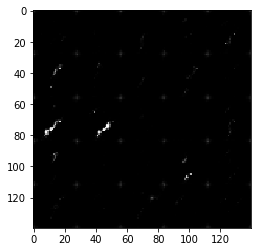

Epoch 1/2... Discriminator Loss: 0.4784... Generator Loss: 3.9743
Epoch 1/2... Discriminator Loss: 0.4308... Generator Loss: 2.9609
Epoch 1/2... Discriminator Loss: 0.3996... Generator Loss: 3.5386
Epoch 1/2... Discriminator Loss: 0.3929... Generator Loss: 3.4255
Epoch 1/2... Discriminator Loss: 0.3745... Generator Loss: 3.5012
Epoch 1/2... Discriminator Loss: 0.3983... Generator Loss: 3.2241
Epoch 1/2... Discriminator Loss: 0.3624... Generator Loss: 4.6837
Epoch 1/2... Discriminator Loss: 0.4421... Generator Loss: 2.7266
Epoch 1/2... Discriminator Loss: 0.3469... Generator Loss: 6.5041
Epoch 1/2... Discriminator Loss: 0.3881... Generator Loss: 4.4288


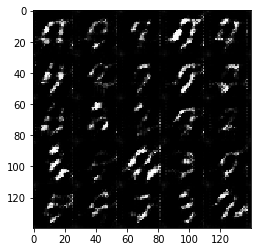

Epoch 1/2... Discriminator Loss: 0.3587... Generator Loss: 4.2719
Epoch 1/2... Discriminator Loss: 0.3490... Generator Loss: 4.7793
Epoch 1/2... Discriminator Loss: 0.3947... Generator Loss: 3.4169
Epoch 1/2... Discriminator Loss: 0.5169... Generator Loss: 3.8475
Epoch 1/2... Discriminator Loss: 0.3677... Generator Loss: 3.7658
Epoch 1/2... Discriminator Loss: 0.3638... Generator Loss: 3.9857
Epoch 1/2... Discriminator Loss: 0.7872... Generator Loss: 11.1835
Epoch 1/2... Discriminator Loss: 0.3556... Generator Loss: 5.6969
Epoch 1/2... Discriminator Loss: 0.3465... Generator Loss: 4.8666
Epoch 1/2... Discriminator Loss: 0.3494... Generator Loss: 5.6728


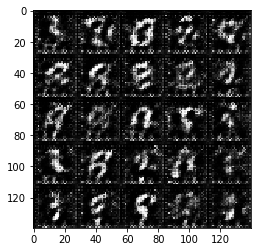

Epoch 1/2... Discriminator Loss: 0.4546... Generator Loss: 4.2702
Epoch 1/2... Discriminator Loss: 0.3392... Generator Loss: 5.4578
Epoch 1/2... Discriminator Loss: 0.3416... Generator Loss: 5.1262
Epoch 1/2... Discriminator Loss: 0.5653... Generator Loss: 2.6341
Epoch 1/2... Discriminator Loss: 0.3431... Generator Loss: 6.1656
Epoch 1/2... Discriminator Loss: 0.3421... Generator Loss: 4.6966
Epoch 1/2... Discriminator Loss: 0.3542... Generator Loss: 3.9060
Epoch 1/2... Discriminator Loss: 0.3714... Generator Loss: 3.8322
Epoch 1/2... Discriminator Loss: 1.0269... Generator Loss: 5.2989
Epoch 1/2... Discriminator Loss: 0.4570... Generator Loss: 2.5894


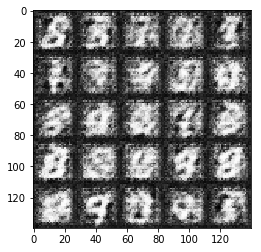

Epoch 1/2... Discriminator Loss: 0.4527... Generator Loss: 3.4087
Epoch 1/2... Discriminator Loss: 0.4288... Generator Loss: 4.3800
Epoch 1/2... Discriminator Loss: 0.3405... Generator Loss: 6.0958
Epoch 1/2... Discriminator Loss: 0.5191... Generator Loss: 2.5707
Epoch 1/2... Discriminator Loss: 0.3780... Generator Loss: 3.6027
Epoch 1/2... Discriminator Loss: 0.4722... Generator Loss: 3.2810
Epoch 1/2... Discriminator Loss: 0.4045... Generator Loss: 3.1201
Epoch 1/2... Discriminator Loss: 0.3912... Generator Loss: 3.0289
Epoch 1/2... Discriminator Loss: 0.3893... Generator Loss: 3.1979
Epoch 1/2... Discriminator Loss: 0.3647... Generator Loss: 6.0211


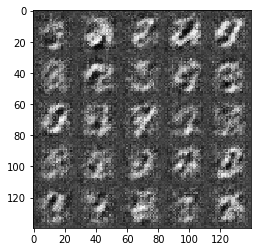

Epoch 1/2... Discriminator Loss: 0.3596... Generator Loss: 3.9754
Epoch 1/2... Discriminator Loss: 0.3852... Generator Loss: 3.8957
Epoch 1/2... Discriminator Loss: 1.9553... Generator Loss: 0.3266
Epoch 1/2... Discriminator Loss: 0.4471... Generator Loss: 2.4710
Epoch 1/2... Discriminator Loss: 0.4121... Generator Loss: 3.0759
Epoch 1/2... Discriminator Loss: 0.3893... Generator Loss: 3.3930
Epoch 1/2... Discriminator Loss: 0.5031... Generator Loss: 4.6425
Epoch 1/2... Discriminator Loss: 0.3826... Generator Loss: 3.6175
Epoch 1/2... Discriminator Loss: 0.3719... Generator Loss: 3.7873
Epoch 1/2... Discriminator Loss: 0.4026... Generator Loss: 4.6645


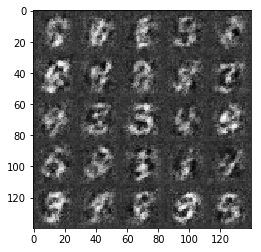

Epoch 1/2... Discriminator Loss: 1.0631... Generator Loss: 2.8428
Epoch 1/2... Discriminator Loss: 0.5018... Generator Loss: 2.7472
Epoch 1/2... Discriminator Loss: 0.4450... Generator Loss: 2.7184
Epoch 1/2... Discriminator Loss: 0.4096... Generator Loss: 2.9400
Epoch 1/2... Discriminator Loss: 0.3856... Generator Loss: 3.4795
Epoch 1/2... Discriminator Loss: 0.3829... Generator Loss: 3.5817
Epoch 1/2... Discriminator Loss: 0.4024... Generator Loss: 3.7321
Epoch 1/2... Discriminator Loss: 0.4005... Generator Loss: 3.0236
Epoch 1/2... Discriminator Loss: 0.4059... Generator Loss: 3.1162
Epoch 1/2... Discriminator Loss: 0.4194... Generator Loss: 2.9110


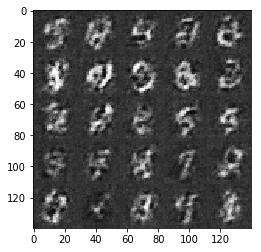

Epoch 1/2... Discriminator Loss: 1.2821... Generator Loss: 4.6818
Epoch 1/2... Discriminator Loss: 0.4857... Generator Loss: 2.6568
Epoch 1/2... Discriminator Loss: 0.4716... Generator Loss: 2.4239
Epoch 1/2... Discriminator Loss: 0.4173... Generator Loss: 3.5594
Epoch 1/2... Discriminator Loss: 0.4288... Generator Loss: 3.5524
Epoch 1/2... Discriminator Loss: 0.4088... Generator Loss: 3.2508
Epoch 1/2... Discriminator Loss: 0.3793... Generator Loss: 3.5911
Epoch 1/2... Discriminator Loss: 0.3936... Generator Loss: 3.2206
Epoch 1/2... Discriminator Loss: 0.4171... Generator Loss: 3.6504
Epoch 1/2... Discriminator Loss: 0.4506... Generator Loss: 2.4171


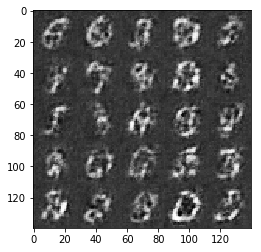

Epoch 1/2... Discriminator Loss: 0.4063... Generator Loss: 3.5162
Epoch 1/2... Discriminator Loss: 0.3882... Generator Loss: 4.2569
Epoch 1/2... Discriminator Loss: 0.3785... Generator Loss: 3.5409
Epoch 2/2... Discriminator Loss: 0.4386... Generator Loss: 2.5917
Epoch 2/2... Discriminator Loss: 0.3678... Generator Loss: 3.4177
Epoch 2/2... Discriminator Loss: 0.5201... Generator Loss: 2.9163
Epoch 2/2... Discriminator Loss: 0.4037... Generator Loss: 2.9961
Epoch 2/2... Discriminator Loss: 0.3813... Generator Loss: 3.4439
Epoch 2/2... Discriminator Loss: 0.3825... Generator Loss: 3.2367
Epoch 2/2... Discriminator Loss: 0.3926... Generator Loss: 3.1893


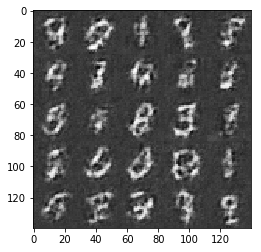

Epoch 2/2... Discriminator Loss: 0.3599... Generator Loss: 3.8756
Epoch 2/2... Discriminator Loss: 0.3749... Generator Loss: 3.3878
Epoch 2/2... Discriminator Loss: 0.4106... Generator Loss: 2.9559
Epoch 2/2... Discriminator Loss: 0.3811... Generator Loss: 3.4017
Epoch 2/2... Discriminator Loss: 0.3824... Generator Loss: 4.1270
Epoch 2/2... Discriminator Loss: 0.3610... Generator Loss: 4.2430
Epoch 2/2... Discriminator Loss: 0.3595... Generator Loss: 3.8671
Epoch 2/2... Discriminator Loss: 0.3802... Generator Loss: 3.8364
Epoch 2/2... Discriminator Loss: 0.3748... Generator Loss: 4.2240
Epoch 2/2... Discriminator Loss: 1.9394... Generator Loss: 0.4941


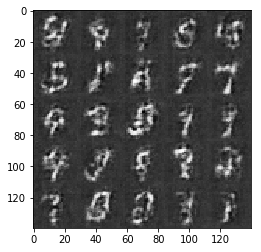

Epoch 2/2... Discriminator Loss: 0.6405... Generator Loss: 1.8657
Epoch 2/2... Discriminator Loss: 0.4572... Generator Loss: 2.8777
Epoch 2/2... Discriminator Loss: 0.4243... Generator Loss: 2.6085
Epoch 2/2... Discriminator Loss: 0.3817... Generator Loss: 3.2643
Epoch 2/2... Discriminator Loss: 0.3842... Generator Loss: 3.2763
Epoch 2/2... Discriminator Loss: 0.3960... Generator Loss: 3.2055
Epoch 2/2... Discriminator Loss: 0.3547... Generator Loss: 4.4656
Epoch 2/2... Discriminator Loss: 0.3785... Generator Loss: 3.2920
Epoch 2/2... Discriminator Loss: 0.3661... Generator Loss: 3.6105
Epoch 2/2... Discriminator Loss: 0.3635... Generator Loss: 3.7879


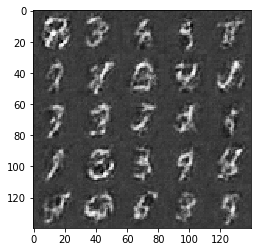

Epoch 2/2... Discriminator Loss: 0.3661... Generator Loss: 3.5404
Epoch 2/2... Discriminator Loss: 0.4448... Generator Loss: 2.7253
Epoch 2/2... Discriminator Loss: 0.3667... Generator Loss: 3.8781
Epoch 2/2... Discriminator Loss: 0.3670... Generator Loss: 3.3240
Epoch 2/2... Discriminator Loss: 0.3588... Generator Loss: 3.9857
Epoch 2/2... Discriminator Loss: 0.3658... Generator Loss: 3.5900
Epoch 2/2... Discriminator Loss: 0.3750... Generator Loss: 4.1432
Epoch 2/2... Discriminator Loss: 0.3623... Generator Loss: 3.6411
Epoch 2/2... Discriminator Loss: 0.3724... Generator Loss: 3.5395
Epoch 2/2... Discriminator Loss: 0.3717... Generator Loss: 4.2890


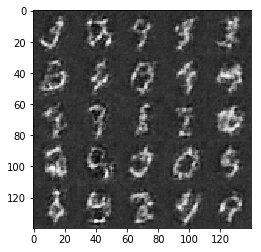

Epoch 2/2... Discriminator Loss: 0.3729... Generator Loss: 3.6303
Epoch 2/2... Discriminator Loss: 0.3548... Generator Loss: 4.0869
Epoch 2/2... Discriminator Loss: 0.3645... Generator Loss: 3.5477
Epoch 2/2... Discriminator Loss: 0.3784... Generator Loss: 3.5209
Epoch 2/2... Discriminator Loss: 0.4277... Generator Loss: 5.2961
Epoch 2/2... Discriminator Loss: 0.3901... Generator Loss: 3.2075
Epoch 2/2... Discriminator Loss: 0.3666... Generator Loss: 3.8813
Epoch 2/2... Discriminator Loss: 0.3514... Generator Loss: 3.8626
Epoch 2/2... Discriminator Loss: 0.3741... Generator Loss: 4.7759
Epoch 2/2... Discriminator Loss: 0.3635... Generator Loss: 3.8293


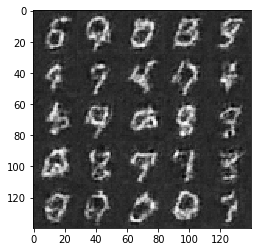

Epoch 2/2... Discriminator Loss: 0.3610... Generator Loss: 4.9511
Epoch 2/2... Discriminator Loss: 0.3629... Generator Loss: 3.8808
Epoch 2/2... Discriminator Loss: 0.3811... Generator Loss: 3.3000
Epoch 2/2... Discriminator Loss: 0.3700... Generator Loss: 3.5734
Epoch 2/2... Discriminator Loss: 6.3526... Generator Loss: 9.0686
Epoch 2/2... Discriminator Loss: 0.8838... Generator Loss: 3.3608
Epoch 2/2... Discriminator Loss: 0.5455... Generator Loss: 2.3231
Epoch 2/2... Discriminator Loss: 0.4327... Generator Loss: 2.5470
Epoch 2/2... Discriminator Loss: 0.4684... Generator Loss: 2.1944
Epoch 2/2... Discriminator Loss: 0.3813... Generator Loss: 3.1951


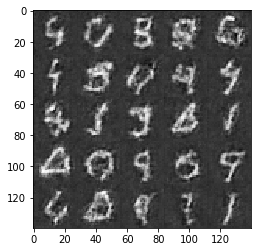

Epoch 2/2... Discriminator Loss: 0.4305... Generator Loss: 2.3891
Epoch 2/2... Discriminator Loss: 0.3944... Generator Loss: 2.9858
Epoch 2/2... Discriminator Loss: 0.3814... Generator Loss: 3.3157
Epoch 2/2... Discriminator Loss: 0.3815... Generator Loss: 3.6469
Epoch 2/2... Discriminator Loss: 0.3941... Generator Loss: 3.3348
Epoch 2/2... Discriminator Loss: 0.3637... Generator Loss: 3.5018
Epoch 2/2... Discriminator Loss: 0.3793... Generator Loss: 4.1430
Epoch 2/2... Discriminator Loss: 0.3816... Generator Loss: 3.2792
Epoch 2/2... Discriminator Loss: 0.3869... Generator Loss: 3.1110
Epoch 2/2... Discriminator Loss: 0.3829... Generator Loss: 3.2863


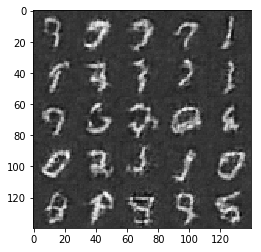

Epoch 2/2... Discriminator Loss: 0.3716... Generator Loss: 3.2873
Epoch 2/2... Discriminator Loss: 0.3685... Generator Loss: 4.0197
Epoch 2/2... Discriminator Loss: 0.3499... Generator Loss: 4.3079
Epoch 2/2... Discriminator Loss: 0.3844... Generator Loss: 3.0675
Epoch 2/2... Discriminator Loss: 0.3725... Generator Loss: 3.2625
Epoch 2/2... Discriminator Loss: 0.3672... Generator Loss: 4.4334
Epoch 2/2... Discriminator Loss: 0.3568... Generator Loss: 3.8346
Epoch 2/2... Discriminator Loss: 0.3588... Generator Loss: 4.3998
Epoch 2/2... Discriminator Loss: 0.3619... Generator Loss: 3.4565
Epoch 2/2... Discriminator Loss: 0.4009... Generator Loss: 3.3497


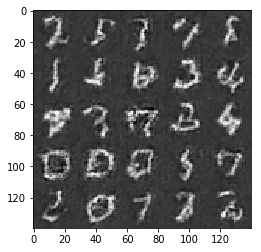

Epoch 2/2... Discriminator Loss: 0.3778... Generator Loss: 3.4661
Epoch 2/2... Discriminator Loss: 0.3534... Generator Loss: 4.2700
Epoch 2/2... Discriminator Loss: 0.3547... Generator Loss: 4.1003
Epoch 2/2... Discriminator Loss: 0.4579... Generator Loss: 2.9745
Epoch 2/2... Discriminator Loss: 5.4886... Generator Loss: 6.8522
Epoch 2/2... Discriminator Loss: 1.0242... Generator Loss: 1.1406
Epoch 2/2... Discriminator Loss: 0.8187... Generator Loss: 1.6332
Epoch 2/2... Discriminator Loss: 0.5558... Generator Loss: 2.3083
Epoch 2/2... Discriminator Loss: 0.4640... Generator Loss: 2.4447
Epoch 2/2... Discriminator Loss: 0.3967... Generator Loss: 3.1032


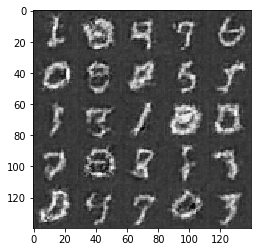

Epoch 2/2... Discriminator Loss: 0.3735... Generator Loss: 3.6792
Epoch 2/2... Discriminator Loss: 0.4621... Generator Loss: 2.5386
Epoch 2/2... Discriminator Loss: 0.4011... Generator Loss: 2.9411
Epoch 2/2... Discriminator Loss: 0.3556... Generator Loss: 4.1262
Epoch 2/2... Discriminator Loss: 0.3647... Generator Loss: 3.9017
Epoch 2/2... Discriminator Loss: 0.3641... Generator Loss: 4.2287
Epoch 2/2... Discriminator Loss: 0.3650... Generator Loss: 3.9478


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

# CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4863... Generator Loss: 2.3466
Epoch 1/1... Discriminator Loss: 0.6182... Generator Loss: 1.7181
Epoch 1/1... Discriminator Loss: 0.3848... Generator Loss: 4.1389
Epoch 1/1... Discriminator Loss: 0.3836... Generator Loss: 4.1111
Epoch 1/1... Discriminator Loss: 0.3525... Generator Loss: 5.0576
Epoch 1/1... Discriminator Loss: 0.3529... Generator Loss: 6.1931
Epoch 1/1... Discriminator Loss: 0.3698... Generator Loss: 3.9434
Epoch 1/1... Discriminator Loss: 0.3490... Generator Loss: 5.1499
Epoch 1/1... Discriminator Loss: 2.2293... Generator Loss: 20.9170
Epoch 1/1... Discriminator Loss: 0.4237... Generator Loss: 5.1695


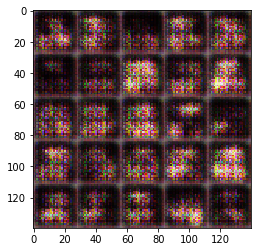

Epoch 1/1... Discriminator Loss: 0.5095... Generator Loss: 2.5298
Epoch 1/1... Discriminator Loss: 0.5391... Generator Loss: 2.9562
Epoch 1/1... Discriminator Loss: 0.4109... Generator Loss: 3.8850
Epoch 1/1... Discriminator Loss: 0.6117... Generator Loss: 1.9602
Epoch 1/1... Discriminator Loss: 0.4618... Generator Loss: 2.9588
Epoch 1/1... Discriminator Loss: 0.4408... Generator Loss: 4.1877
Epoch 1/1... Discriminator Loss: 0.5098... Generator Loss: 3.7808
Epoch 1/1... Discriminator Loss: 0.4380... Generator Loss: 3.3711
Epoch 1/1... Discriminator Loss: 0.3833... Generator Loss: 4.3795
Epoch 1/1... Discriminator Loss: 0.4125... Generator Loss: 3.0522


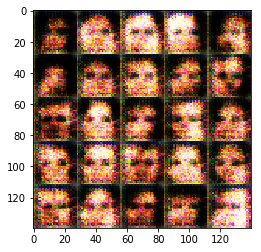

Epoch 1/1... Discriminator Loss: 0.3785... Generator Loss: 4.8701
Epoch 1/1... Discriminator Loss: 0.3877... Generator Loss: 3.5490
Epoch 1/1... Discriminator Loss: 0.4237... Generator Loss: 3.0959
Epoch 1/1... Discriminator Loss: 0.4329... Generator Loss: 3.0027
Epoch 1/1... Discriminator Loss: 0.3789... Generator Loss: 3.7875
Epoch 1/1... Discriminator Loss: 0.3714... Generator Loss: 4.2893
Epoch 1/1... Discriminator Loss: 0.3917... Generator Loss: 4.3638
Epoch 1/1... Discriminator Loss: 0.3767... Generator Loss: 3.8145
Epoch 1/1... Discriminator Loss: 0.3641... Generator Loss: 4.3324
Epoch 1/1... Discriminator Loss: 0.3604... Generator Loss: 4.4314


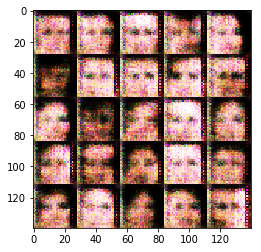

Epoch 1/1... Discriminator Loss: 0.3547... Generator Loss: 4.5946
Epoch 1/1... Discriminator Loss: 0.5108... Generator Loss: 2.2391
Epoch 1/1... Discriminator Loss: 0.3749... Generator Loss: 3.5238
Epoch 1/1... Discriminator Loss: 0.3730... Generator Loss: 3.9988
Epoch 1/1... Discriminator Loss: 0.3709... Generator Loss: 3.6969
Epoch 1/1... Discriminator Loss: 0.3798... Generator Loss: 3.3446
Epoch 1/1... Discriminator Loss: 0.3562... Generator Loss: 5.1665
Epoch 1/1... Discriminator Loss: 0.4091... Generator Loss: 2.9449
Epoch 1/1... Discriminator Loss: 0.3920... Generator Loss: 4.6277
Epoch 1/1... Discriminator Loss: 0.5055... Generator Loss: 2.1964


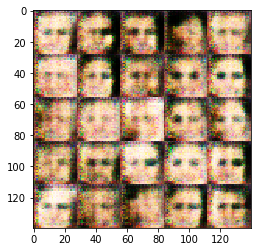

Epoch 1/1... Discriminator Loss: 0.6126... Generator Loss: 2.9306
Epoch 1/1... Discriminator Loss: 0.4277... Generator Loss: 3.3516
Epoch 1/1... Discriminator Loss: 0.3823... Generator Loss: 4.1399
Epoch 1/1... Discriminator Loss: 0.4604... Generator Loss: 2.4833
Epoch 1/1... Discriminator Loss: 0.3669... Generator Loss: 4.8944
Epoch 1/1... Discriminator Loss: 0.3930... Generator Loss: 3.6489
Epoch 1/1... Discriminator Loss: 0.3896... Generator Loss: 4.3075
Epoch 1/1... Discriminator Loss: 0.3717... Generator Loss: 4.7080
Epoch 1/1... Discriminator Loss: 0.3713... Generator Loss: 3.7881
Epoch 1/1... Discriminator Loss: 0.3634... Generator Loss: 4.5165


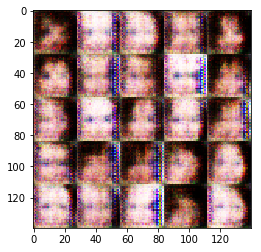

Epoch 1/1... Discriminator Loss: 0.4169... Generator Loss: 2.7943
Epoch 1/1... Discriminator Loss: 0.3693... Generator Loss: 4.0064
Epoch 1/1... Discriminator Loss: 0.3680... Generator Loss: 3.9925
Epoch 1/1... Discriminator Loss: 0.3741... Generator Loss: 4.1845
Epoch 1/1... Discriminator Loss: 0.3665... Generator Loss: 3.7030
Epoch 1/1... Discriminator Loss: 0.5468... Generator Loss: 2.3625
Epoch 1/1... Discriminator Loss: 0.5299... Generator Loss: 2.8586
Epoch 1/1... Discriminator Loss: 0.4826... Generator Loss: 3.3435
Epoch 1/1... Discriminator Loss: 0.4409... Generator Loss: 3.0025
Epoch 1/1... Discriminator Loss: 0.4923... Generator Loss: 2.3268


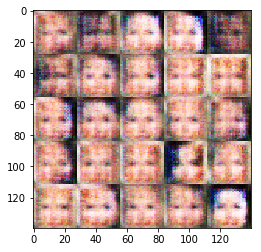

Epoch 1/1... Discriminator Loss: 0.5037... Generator Loss: 3.3062
Epoch 1/1... Discriminator Loss: 0.4374... Generator Loss: 2.8730
Epoch 1/1... Discriminator Loss: 0.4813... Generator Loss: 2.6406
Epoch 1/1... Discriminator Loss: 0.4398... Generator Loss: 3.1102
Epoch 1/1... Discriminator Loss: 0.4892... Generator Loss: 3.6805
Epoch 1/1... Discriminator Loss: 0.3757... Generator Loss: 4.2614
Epoch 1/1... Discriminator Loss: 0.5456... Generator Loss: 2.3849
Epoch 1/1... Discriminator Loss: 0.5289... Generator Loss: 2.9729
Epoch 1/1... Discriminator Loss: 0.4215... Generator Loss: 3.3908
Epoch 1/1... Discriminator Loss: 0.4037... Generator Loss: 3.1546


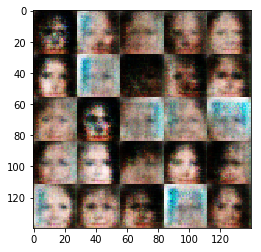

Epoch 1/1... Discriminator Loss: 0.5052... Generator Loss: 2.3259
Epoch 1/1... Discriminator Loss: 0.6045... Generator Loss: 2.0583
Epoch 1/1... Discriminator Loss: 0.4655... Generator Loss: 3.4534
Epoch 1/1... Discriminator Loss: 0.4619... Generator Loss: 4.1568
Epoch 1/1... Discriminator Loss: 0.4704... Generator Loss: 3.0673
Epoch 1/1... Discriminator Loss: 0.5925... Generator Loss: 5.1723
Epoch 1/1... Discriminator Loss: 0.4549... Generator Loss: 2.9330
Epoch 1/1... Discriminator Loss: 0.4302... Generator Loss: 3.2726
Epoch 1/1... Discriminator Loss: 0.5321... Generator Loss: 2.1847
Epoch 1/1... Discriminator Loss: 0.4208... Generator Loss: 3.3367


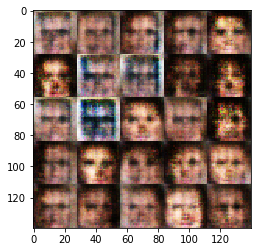

Epoch 1/1... Discriminator Loss: 0.4564... Generator Loss: 2.6536
Epoch 1/1... Discriminator Loss: 0.4717... Generator Loss: 2.4608
Epoch 1/1... Discriminator Loss: 0.5663... Generator Loss: 2.0218
Epoch 1/1... Discriminator Loss: 0.5199... Generator Loss: 2.4818
Epoch 1/1... Discriminator Loss: 0.4474... Generator Loss: 3.0396
Epoch 1/1... Discriminator Loss: 0.4601... Generator Loss: 2.4804
Epoch 1/1... Discriminator Loss: 0.5999... Generator Loss: 1.8462
Epoch 1/1... Discriminator Loss: 0.4492... Generator Loss: 3.4218
Epoch 1/1... Discriminator Loss: 0.4410... Generator Loss: 4.3327
Epoch 1/1... Discriminator Loss: 0.4714... Generator Loss: 2.8571


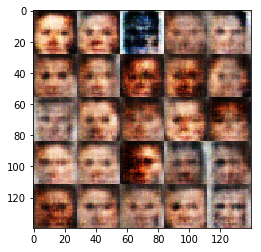

Epoch 1/1... Discriminator Loss: 0.4766... Generator Loss: 2.4457
Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 0.6215... Generator Loss: 4.3985
Epoch 1/1... Discriminator Loss: 0.4450... Generator Loss: 3.0038
Epoch 1/1... Discriminator Loss: 0.5794... Generator Loss: 2.0454
Epoch 1/1... Discriminator Loss: 0.5361... Generator Loss: 2.3158
Epoch 1/1... Discriminator Loss: 0.4560... Generator Loss: 2.9370
Epoch 1/1... Discriminator Loss: 0.5089... Generator Loss: 2.8037
Epoch 1/1... Discriminator Loss: 0.5026... Generator Loss: 3.3214
Epoch 1/1... Discriminator Loss: 0.5125... Generator Loss: 2.7552


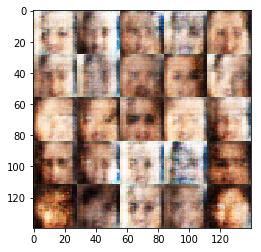

Epoch 1/1... Discriminator Loss: 0.6029... Generator Loss: 2.1137
Epoch 1/1... Discriminator Loss: 0.4724... Generator Loss: 2.7368
Epoch 1/1... Discriminator Loss: 0.5109... Generator Loss: 2.3859
Epoch 1/1... Discriminator Loss: 0.5343... Generator Loss: 2.8540
Epoch 1/1... Discriminator Loss: 0.5511... Generator Loss: 2.3846
Epoch 1/1... Discriminator Loss: 0.5565... Generator Loss: 2.3145
Epoch 1/1... Discriminator Loss: 0.4881... Generator Loss: 2.7002
Epoch 1/1... Discriminator Loss: 0.7422... Generator Loss: 1.4510
Epoch 1/1... Discriminator Loss: 0.7509... Generator Loss: 1.2455
Epoch 1/1... Discriminator Loss: 0.5986... Generator Loss: 1.9201


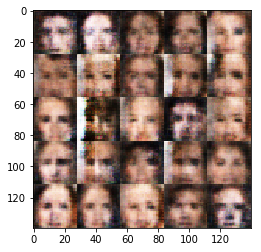

Epoch 1/1... Discriminator Loss: 0.4977... Generator Loss: 2.5005
Epoch 1/1... Discriminator Loss: 0.4584... Generator Loss: 3.8319
Epoch 1/1... Discriminator Loss: 0.5381... Generator Loss: 2.3908
Epoch 1/1... Discriminator Loss: 0.6785... Generator Loss: 1.6470
Epoch 1/1... Discriminator Loss: 0.6066... Generator Loss: 1.7877
Epoch 1/1... Discriminator Loss: 0.5027... Generator Loss: 2.8021
Epoch 1/1... Discriminator Loss: 0.5237... Generator Loss: 2.8002
Epoch 1/1... Discriminator Loss: 0.4803... Generator Loss: 2.7255
Epoch 1/1... Discriminator Loss: 0.9182... Generator Loss: 1.0809
Epoch 1/1... Discriminator Loss: 0.6065... Generator Loss: 1.8707


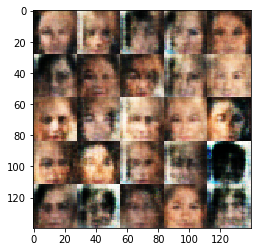

Epoch 1/1... Discriminator Loss: 0.6047... Generator Loss: 2.0767
Epoch 1/1... Discriminator Loss: 0.5133... Generator Loss: 2.4497
Epoch 1/1... Discriminator Loss: 0.5315... Generator Loss: 2.9456
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 5.5720
Epoch 1/1... Discriminator Loss: 0.5030... Generator Loss: 2.5951
Epoch 1/1... Discriminator Loss: 0.5694... Generator Loss: 1.9994
Epoch 1/1... Discriminator Loss: 0.6184... Generator Loss: 1.8476
Epoch 1/1... Discriminator Loss: 0.7754... Generator Loss: 1.2177
Epoch 1/1... Discriminator Loss: 0.6015... Generator Loss: 2.0257
Epoch 1/1... Discriminator Loss: 0.8301... Generator Loss: 1.2744


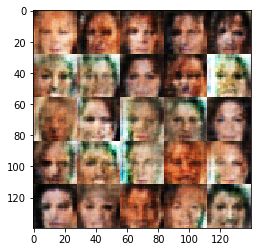

Epoch 1/1... Discriminator Loss: 0.5223... Generator Loss: 2.8925
Epoch 1/1... Discriminator Loss: 0.4972... Generator Loss: 2.8635
Epoch 1/1... Discriminator Loss: 0.6595... Generator Loss: 1.6503
Epoch 1/1... Discriminator Loss: 0.8499... Generator Loss: 1.1866
Epoch 1/1... Discriminator Loss: 0.5600... Generator Loss: 2.2800
Epoch 1/1... Discriminator Loss: 0.7691... Generator Loss: 1.5974
Epoch 1/1... Discriminator Loss: 0.5558... Generator Loss: 2.0506
Epoch 1/1... Discriminator Loss: 0.6384... Generator Loss: 2.8103
Epoch 1/1... Discriminator Loss: 0.7068... Generator Loss: 1.5797
Epoch 1/1... Discriminator Loss: 0.6384... Generator Loss: 1.9066


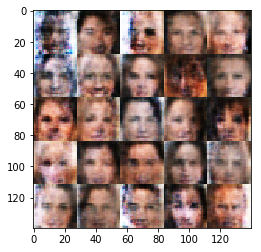

Epoch 1/1... Discriminator Loss: 0.5915... Generator Loss: 2.4092
Epoch 1/1... Discriminator Loss: 0.5691... Generator Loss: 2.8483
Epoch 1/1... Discriminator Loss: 0.5902... Generator Loss: 1.9936
Epoch 1/1... Discriminator Loss: 0.5739... Generator Loss: 2.5707
Epoch 1/1... Discriminator Loss: 0.6861... Generator Loss: 1.6560
Epoch 1/1... Discriminator Loss: 0.5501... Generator Loss: 2.2754
Epoch 1/1... Discriminator Loss: 0.5349... Generator Loss: 2.7509
Epoch 1/1... Discriminator Loss: 0.5139... Generator Loss: 3.0806
Epoch 1/1... Discriminator Loss: 0.6200... Generator Loss: 2.0662
Epoch 1/1... Discriminator Loss: 0.5794... Generator Loss: 2.3107


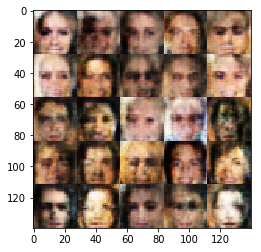

Epoch 1/1... Discriminator Loss: 0.5743... Generator Loss: 1.9067
Epoch 1/1... Discriminator Loss: 0.6576... Generator Loss: 3.0444
Epoch 1/1... Discriminator Loss: 0.6864... Generator Loss: 1.6000
Epoch 1/1... Discriminator Loss: 0.5078... Generator Loss: 2.7499
Epoch 1/1... Discriminator Loss: 0.5836... Generator Loss: 3.1137
Epoch 1/1... Discriminator Loss: 0.6603... Generator Loss: 1.6910
Epoch 1/1... Discriminator Loss: 0.5449... Generator Loss: 2.6992
Epoch 1/1... Discriminator Loss: 0.5423... Generator Loss: 3.3366
Epoch 1/1... Discriminator Loss: 0.5463... Generator Loss: 2.7067
Epoch 1/1... Discriminator Loss: 0.5985... Generator Loss: 2.1513


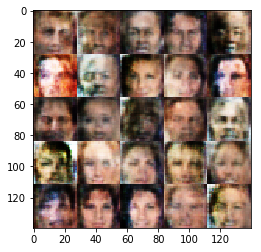

Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 1.0318
Epoch 1/1... Discriminator Loss: 0.5179... Generator Loss: 2.6912
Epoch 1/1... Discriminator Loss: 0.9087... Generator Loss: 1.1398
Epoch 1/1... Discriminator Loss: 0.8574... Generator Loss: 3.7153
Epoch 1/1... Discriminator Loss: 0.8768... Generator Loss: 3.7075
Epoch 1/1... Discriminator Loss: 0.8055... Generator Loss: 1.4120
Epoch 1/1... Discriminator Loss: 0.6757... Generator Loss: 1.6673
Epoch 1/1... Discriminator Loss: 0.6706... Generator Loss: 2.8794
Epoch 1/1... Discriminator Loss: 0.6157... Generator Loss: 2.3848
Epoch 1/1... Discriminator Loss: 0.5619... Generator Loss: 2.6226


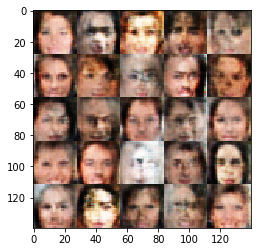

Epoch 1/1... Discriminator Loss: 0.8389... Generator Loss: 1.3390
Epoch 1/1... Discriminator Loss: 0.8613... Generator Loss: 1.1635
Epoch 1/1... Discriminator Loss: 1.0408... Generator Loss: 4.6617
Epoch 1/1... Discriminator Loss: 0.6222... Generator Loss: 1.8733
Epoch 1/1... Discriminator Loss: 0.6327... Generator Loss: 1.7761
Epoch 1/1... Discriminator Loss: 0.6322... Generator Loss: 1.9008
Epoch 1/1... Discriminator Loss: 0.8517... Generator Loss: 1.0680
Epoch 1/1... Discriminator Loss: 0.6626... Generator Loss: 1.7000
Epoch 1/1... Discriminator Loss: 1.0584... Generator Loss: 0.9366
Epoch 1/1... Discriminator Loss: 0.6155... Generator Loss: 1.9456


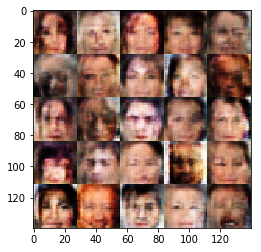

Epoch 1/1... Discriminator Loss: 0.6627... Generator Loss: 1.7126
Epoch 1/1... Discriminator Loss: 0.5778... Generator Loss: 1.8894
Epoch 1/1... Discriminator Loss: 0.7358... Generator Loss: 1.4425
Epoch 1/1... Discriminator Loss: 0.7516... Generator Loss: 1.4946
Epoch 1/1... Discriminator Loss: 0.5913... Generator Loss: 2.1281
Epoch 1/1... Discriminator Loss: 0.5526... Generator Loss: 2.5756
Epoch 1/1... Discriminator Loss: 0.6197... Generator Loss: 1.8375
Epoch 1/1... Discriminator Loss: 0.7130... Generator Loss: 1.3310
Epoch 1/1... Discriminator Loss: 0.6188... Generator Loss: 3.2031
Epoch 1/1... Discriminator Loss: 1.8920... Generator Loss: 0.4541


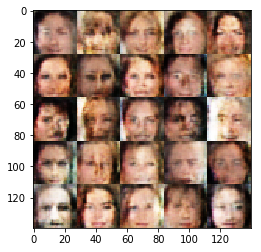

Epoch 1/1... Discriminator Loss: 0.7981... Generator Loss: 1.5238
Epoch 1/1... Discriminator Loss: 0.6342... Generator Loss: 2.0714
Epoch 1/1... Discriminator Loss: 0.7772... Generator Loss: 1.3590
Epoch 1/1... Discriminator Loss: 0.6375... Generator Loss: 2.6585
Epoch 1/1... Discriminator Loss: 0.6462... Generator Loss: 2.7128
Epoch 1/1... Discriminator Loss: 0.7430... Generator Loss: 1.3170
Epoch 1/1... Discriminator Loss: 0.7273... Generator Loss: 3.6040
Epoch 1/1... Discriminator Loss: 0.5793... Generator Loss: 1.9329
Epoch 1/1... Discriminator Loss: 0.6488... Generator Loss: 1.6363
Epoch 1/1... Discriminator Loss: 0.5476... Generator Loss: 2.3570


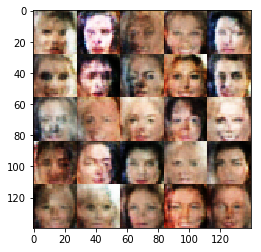

Epoch 1/1... Discriminator Loss: 0.5554... Generator Loss: 2.4760
Epoch 1/1... Discriminator Loss: 0.6262... Generator Loss: 2.5337
Epoch 1/1... Discriminator Loss: 0.8571... Generator Loss: 4.5375
Epoch 1/1... Discriminator Loss: 0.4768... Generator Loss: 2.7621
Epoch 1/1... Discriminator Loss: 0.5271... Generator Loss: 2.7411
Epoch 1/1... Discriminator Loss: 0.6225... Generator Loss: 2.9615
Epoch 1/1... Discriminator Loss: 0.6440... Generator Loss: 2.0372
Epoch 1/1... Discriminator Loss: 0.5942... Generator Loss: 2.5302
Epoch 1/1... Discriminator Loss: 0.9396... Generator Loss: 1.1363
Epoch 1/1... Discriminator Loss: 0.7044... Generator Loss: 1.4208


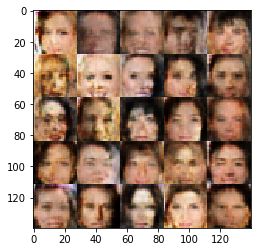

Epoch 1/1... Discriminator Loss: 0.6261... Generator Loss: 1.8060
Epoch 1/1... Discriminator Loss: 0.5628... Generator Loss: 2.5406
Epoch 1/1... Discriminator Loss: 0.5881... Generator Loss: 1.9355
Epoch 1/1... Discriminator Loss: 0.8780... Generator Loss: 1.1371
Epoch 1/1... Discriminator Loss: 0.6418... Generator Loss: 1.5580
Epoch 1/1... Discriminator Loss: 0.7799... Generator Loss: 1.3612
Epoch 1/1... Discriminator Loss: 0.6403... Generator Loss: 1.8038
Epoch 1/1... Discriminator Loss: 0.6981... Generator Loss: 1.7709
Epoch 1/1... Discriminator Loss: 0.6102... Generator Loss: 1.9386
Epoch 1/1... Discriminator Loss: 0.6575... Generator Loss: 2.1407


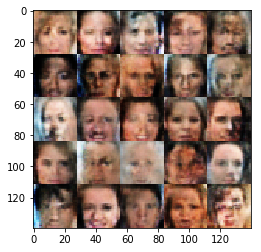

Epoch 1/1... Discriminator Loss: 0.6080... Generator Loss: 2.5407
Epoch 1/1... Discriminator Loss: 0.6038... Generator Loss: 2.0033
Epoch 1/1... Discriminator Loss: 0.8709... Generator Loss: 1.0753
Epoch 1/1... Discriminator Loss: 0.5559... Generator Loss: 2.3405
Epoch 1/1... Discriminator Loss: 0.7386... Generator Loss: 1.3866
Epoch 1/1... Discriminator Loss: 0.5087... Generator Loss: 2.1835
Epoch 1/1... Discriminator Loss: 1.0485... Generator Loss: 3.9295
Epoch 1/1... Discriminator Loss: 0.6569... Generator Loss: 1.7405
Epoch 1/1... Discriminator Loss: 0.9137... Generator Loss: 1.2042
Epoch 1/1... Discriminator Loss: 0.5452... Generator Loss: 2.1906


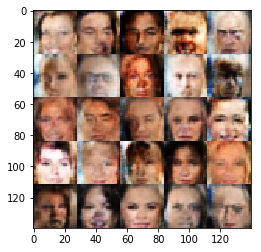

Epoch 1/1... Discriminator Loss: 0.7257... Generator Loss: 2.8218
Epoch 1/1... Discriminator Loss: 0.8965... Generator Loss: 1.1176
Epoch 1/1... Discriminator Loss: 0.8627... Generator Loss: 1.1028
Epoch 1/1... Discriminator Loss: 0.6949... Generator Loss: 1.5205
Epoch 1/1... Discriminator Loss: 0.7243... Generator Loss: 1.4897
Epoch 1/1... Discriminator Loss: 0.6935... Generator Loss: 1.4509
Epoch 1/1... Discriminator Loss: 0.7824... Generator Loss: 1.3459
Epoch 1/1... Discriminator Loss: 0.6509... Generator Loss: 1.4820
Epoch 1/1... Discriminator Loss: 0.5559... Generator Loss: 2.5218
Epoch 1/1... Discriminator Loss: 0.6408... Generator Loss: 1.5669


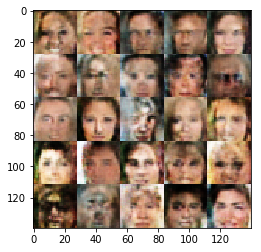

Epoch 1/1... Discriminator Loss: 0.5900... Generator Loss: 2.9974
Epoch 1/1... Discriminator Loss: 0.7684... Generator Loss: 3.2612
Epoch 1/1... Discriminator Loss: 0.5086... Generator Loss: 2.2405
Epoch 1/1... Discriminator Loss: 0.6828... Generator Loss: 1.6932
Epoch 1/1... Discriminator Loss: 0.6729... Generator Loss: 1.6151
Epoch 1/1... Discriminator Loss: 0.6063... Generator Loss: 1.8868
Epoch 1/1... Discriminator Loss: 0.6093... Generator Loss: 1.9665
Epoch 1/1... Discriminator Loss: 0.4889... Generator Loss: 3.1851
Epoch 1/1... Discriminator Loss: 0.7359... Generator Loss: 1.3661
Epoch 1/1... Discriminator Loss: 0.9626... Generator Loss: 4.1924


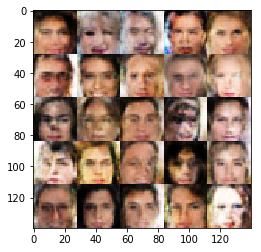

Epoch 1/1... Discriminator Loss: 0.6475... Generator Loss: 1.9868
Epoch 1/1... Discriminator Loss: 0.6055... Generator Loss: 2.1429
Epoch 1/1... Discriminator Loss: 0.7202... Generator Loss: 1.5304
Epoch 1/1... Discriminator Loss: 0.9944... Generator Loss: 0.8815
Epoch 1/1... Discriminator Loss: 0.6543... Generator Loss: 1.5653
Epoch 1/1... Discriminator Loss: 0.5469... Generator Loss: 2.0267
Epoch 1/1... Discriminator Loss: 0.5914... Generator Loss: 1.7003
Epoch 1/1... Discriminator Loss: 0.6930... Generator Loss: 2.0479
Epoch 1/1... Discriminator Loss: 0.7706... Generator Loss: 1.3555
Epoch 1/1... Discriminator Loss: 0.8242... Generator Loss: 1.2676


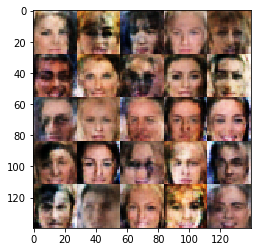

Epoch 1/1... Discriminator Loss: 1.0328... Generator Loss: 0.9204
Epoch 1/1... Discriminator Loss: 0.6856... Generator Loss: 2.1211
Epoch 1/1... Discriminator Loss: 0.7427... Generator Loss: 1.5549
Epoch 1/1... Discriminator Loss: 0.6107... Generator Loss: 1.8168
Epoch 1/1... Discriminator Loss: 0.6555... Generator Loss: 2.8519
Epoch 1/1... Discriminator Loss: 1.9498... Generator Loss: 4.5513
Epoch 1/1... Discriminator Loss: 0.5478... Generator Loss: 2.4640
Epoch 1/1... Discriminator Loss: 0.7306... Generator Loss: 1.4664
Epoch 1/1... Discriminator Loss: 0.7344... Generator Loss: 1.5013
Epoch 1/1... Discriminator Loss: 0.6452... Generator Loss: 1.6247


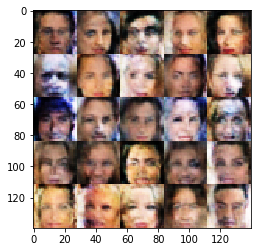

Epoch 1/1... Discriminator Loss: 0.7403... Generator Loss: 2.0378
Epoch 1/1... Discriminator Loss: 0.6092... Generator Loss: 1.8092
Epoch 1/1... Discriminator Loss: 0.4932... Generator Loss: 2.8082
Epoch 1/1... Discriminator Loss: 0.6606... Generator Loss: 1.8425
Epoch 1/1... Discriminator Loss: 0.8062... Generator Loss: 1.3983
Epoch 1/1... Discriminator Loss: 0.5433... Generator Loss: 1.9948
Epoch 1/1... Discriminator Loss: 0.9658... Generator Loss: 0.9087
Epoch 1/1... Discriminator Loss: 0.6316... Generator Loss: 2.5960
Epoch 1/1... Discriminator Loss: 0.7077... Generator Loss: 1.7053
Epoch 1/1... Discriminator Loss: 0.6425... Generator Loss: 1.5978


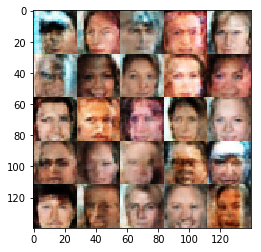

Epoch 1/1... Discriminator Loss: 0.8533... Generator Loss: 1.1268
Epoch 1/1... Discriminator Loss: 0.6226... Generator Loss: 1.7817
Epoch 1/1... Discriminator Loss: 0.7369... Generator Loss: 1.4817
Epoch 1/1... Discriminator Loss: 0.5788... Generator Loss: 1.8887
Epoch 1/1... Discriminator Loss: 0.6470... Generator Loss: 1.4351
Epoch 1/1... Discriminator Loss: 1.6524... Generator Loss: 0.5205
Epoch 1/1... Discriminator Loss: 0.8586... Generator Loss: 1.2387
Epoch 1/1... Discriminator Loss: 0.9320... Generator Loss: 0.9526
Epoch 1/1... Discriminator Loss: 0.5588... Generator Loss: 2.5432
Epoch 1/1... Discriminator Loss: 0.6260... Generator Loss: 1.7980


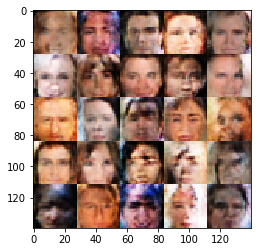

Epoch 1/1... Discriminator Loss: 0.5637... Generator Loss: 2.0340
Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 0.6284... Generator Loss: 2.2318
Epoch 1/1... Discriminator Loss: 0.6188... Generator Loss: 1.9952
Epoch 1/1... Discriminator Loss: 0.6130... Generator Loss: 2.1486
Epoch 1/1... Discriminator Loss: 0.9808... Generator Loss: 1.0886
Epoch 1/1... Discriminator Loss: 0.6236... Generator Loss: 2.6674
Epoch 1/1... Discriminator Loss: 0.9582... Generator Loss: 0.9866
Epoch 1/1... Discriminator Loss: 0.6341... Generator Loss: 1.8096
Epoch 1/1... Discriminator Loss: 0.7450... Generator Loss: 1.3876


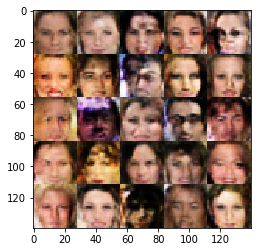

Epoch 1/1... Discriminator Loss: 0.5716... Generator Loss: 2.2179
Epoch 1/1... Discriminator Loss: 0.6246... Generator Loss: 1.9464
Epoch 1/1... Discriminator Loss: 0.6291... Generator Loss: 2.4447
Epoch 1/1... Discriminator Loss: 0.5407... Generator Loss: 2.5548
Epoch 1/1... Discriminator Loss: 0.6745... Generator Loss: 1.5195
Epoch 1/1... Discriminator Loss: 0.6841... Generator Loss: 1.5798
Epoch 1/1... Discriminator Loss: 0.6139... Generator Loss: 1.8986
Epoch 1/1... Discriminator Loss: 0.8791... Generator Loss: 1.0226
Epoch 1/1... Discriminator Loss: 0.7859... Generator Loss: 1.2440
Epoch 1/1... Discriminator Loss: 0.8919... Generator Loss: 3.0066


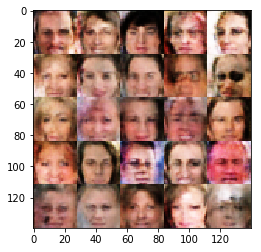

Epoch 1/1... Discriminator Loss: 0.9114... Generator Loss: 1.1127
Epoch 1/1... Discriminator Loss: 0.5100... Generator Loss: 2.7459
Epoch 1/1... Discriminator Loss: 0.6501... Generator Loss: 1.5532
Epoch 1/1... Discriminator Loss: 0.6245... Generator Loss: 2.5530
Epoch 1/1... Discriminator Loss: 0.6382... Generator Loss: 2.1205
Epoch 1/1... Discriminator Loss: 1.0594... Generator Loss: 0.7406


In [15]:
batch_size = 64
z_dim = 200
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.